# 2.4.5. Использование обученных моделей RusVectōrēs для классификации текста.  


Видеоуроки:  
2.4.1. Векторное представление единиц текста.  
2.4.2. Обучение нейросетевой модели word2vec.  
2.4.3. Использование обученных моделей RusVectōrēs.  
2.4.4. Нейросетевая модель torch.embedding.  

Дополнительные материалы:  
**2.4.5. Использование обученных моделей RusVectōrēs для классификации (анализа тональности) текста.**  
2.4.6. Использование моделей Hugging Face для классификации (анализа тональности) текста.  

В предыдущей теме мы рассмотрели сервис [RusVectōrēs](https://rusvectores.org/ru/about/), который вычисляет семантические отношения между словами русского языка и позволяет скачать предобученные дистрибутивно-семантические модели (word embeddings).  

В данной теме применим готовые модели для классификации текстов новостей.  
Для примера рассмотрим датасет новостей, собранных из различных новостных сайтов и размеченный вручную.  
Страница ресурса: https://www.kaggle.com/c/sentiment-analysis-in-russian  
Так же датасет можно скачать из другого источника - https://data.mendeley.com/datasets/m4ndy7tcss/2  
Во втором случае нужен файл `sentiment-analysis-in-russian-lemmatized-topic.zip` - скачайте и распакуйте архив вручную.  

In [78]:
import warnings
import logging
from functools import partial
import zipfile
from time import time
import wget
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gensim
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn import metrics
from sklearn.svm import LinearSVC
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import resample
from utils import reset_random_seeds

RANDOM_SEED = 42
reset_random_seeds(RANDOM_SEED)
plt.style.use('ggplot')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
warnings.filterwarnings('ignore')

In [158]:
! ls ./data/sentiment

sentiment-analysis-in-russian-lemmatized-topic.csv


In [159]:
df_src = pd.read_csv('./data/sentiment/sentiment-analysis-in-russian-lemmatized-topic.csv', sep=';', encoding='utf-8')
df_src.head()

,text,id,sentiment,Lemmed text,Topic label normalized
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative,досудебный расследование по факт покупка енпф ...,fin
1,Медики рассказали о состоянии пострадавшего му...,1957,negative,медик рассказать о состояние пострадавший мужч...,accid
2,"Прошел почти год, как железнодорожным оператор...",1969,negative,пройти почти год как железнодорожный оператор ...,kz
3,По итогам 12 месяцев 2016 года на территории р...,1973,negative,по итог месяц год на территория республика вып...,fin
4,Астана. 21 ноября. Kazakhstan Today - Агентств...,1975,negative,астан ноябрь агентство рк по дело государствен...,kz


In [160]:
df_src.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8263 entries, 0 to 8262
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   text                    8263 non-null   object
 1   id                      8263 non-null   int64 
 2   sentiment               8263 non-null   object
 3   Lemmed text             8263 non-null   object
 4   Topic label normalized  8263 non-null   object
dtypes: int64(1), object(4)
memory usage: 322.9+ KB


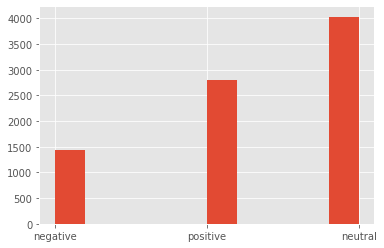

neutral     4034
positive    2795
negative    1434
Name: sentiment, dtype: int64

In [161]:
Y_COL = 'sentiment'
TEXT_COL = 'text'
df_src[Y_COL].hist()
plt.show()

df_src[Y_COL].value_counts()

Мы видим сильно несбаллансированы данные - модель может переобучаться (может всегда давать ответ "нейтральный") и будет права в большинстве случаев.  
Применим самый простой подход - undersampling (уменьшим количество примеров классов).  


min n: 1434
min label: negative


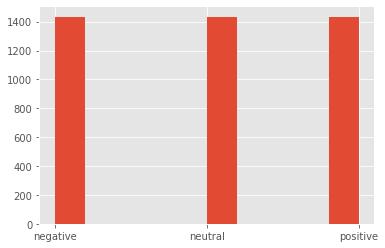

negative    1434
neutral     1434
positive    1434
Name: sentiment, dtype: int64

In [148]:
vc = df_src[Y_COL].value_counts()
min_n = vc.min()

min_label = vc[vc == min_n].index[0]

print('min n:', min_n)
print('min label:', min_label)

df = df_src[df_src[Y_COL] == min_label]

for label, n in df_src[Y_COL].value_counts().items():
    if label != min_label:
        _df = resample(df_src[df_src[Y_COL] == label], replace=False, n_samples=min_n, random_state=RANDOM_SEED)
        df = pd.concat([df, _df], ignore_index=True)

df.reset_index(drop=True, inplace=True)

df[Y_COL].hist()
plt.show()
df[Y_COL].value_counts()

В данных могут встречаться редкие слова (например фамилии). Целесообразно использовать модель на основе fasttext.  

In [149]:
MODEL_FT_URL = 'http://vectors.nlpl.eu/repository/20/181.zip'

model_arch_file = MODEL_FT_URL.split('/')[-1]
model_path = model_arch_file.split('.')[0]

In [150]:
# Скачивание модели.
# размер файла - 2,6 Gb.
# Не выполняйте этот код повторно, если модель уже скачана и распакована.

# _ = wget.download(MODEL_FT_URL)
# print(f'extract {model_arch_file} to path: {model_path}')
# with zipfile.ZipFile(model_file, 'r') as archive:
#     zipfile.ZipFile.extractall(archive, model_path)

In [151]:
model_ft = gensim.models.KeyedVectors.load(f'{model_path}/model.model')

2022-01-19 19:13:00,403 : INFO : loading Word2VecKeyedVectors object from 181/model.model
2022-01-19 19:13:01,722 : INFO : loading vectors_vocab from 181/model.model.vectors_vocab.npy with mmap=None
2022-01-19 19:13:02,072 : INFO : loading vectors_ngrams from 181/model.model.vectors_ngrams.npy with mmap=None
2022-01-19 19:13:05,167 : INFO : loading vectors from 181/model.model.vectors.npy with mmap=None
2022-01-19 19:13:05,467 : INFO : setting ignored attribute vectors_vocab_norm to None
2022-01-19 19:13:05,477 : INFO : setting ignored attribute buckets_word to None
2022-01-19 19:13:05,481 : INFO : setting ignored attribute vectors_norm to None
2022-01-19 19:13:05,485 : INFO : setting ignored attribute vectors_ngrams_norm to None
2022-01-19 19:13:05,485 : INFO : loaded 181/model.model


Модель может выдавать вектор слова.

In [28]:
word = 'привет'
v = model_ft.get_vector('привет')
print('размер вектора:', v.size)

размер вектора: 300


для того чтобы получить вектор текста - усредним вектора всех слов э того текста.

In [30]:
def get_text_vector(text: str, model: gensim.models.KeyedVectors) -> np.array:
    """
    Получить усредненный вектор слов текста.

    Args:
        text (str): текст.
        model (gensim.models.KeyedVectors): модель.

    Returns:
        np.array: результат.
    """

    tokens = text.split()
    v = np.mean([model.get_vector(t) for t in tokens], axis=0)

    return v

print('размер вектора:', get_text_vector('хливкие шорьки', model_ft).size)

размер вектора: 300


Наш классификатор будет состоять из 2 последовательных шагов (слоёв):  
- векторизация  
- классификация  

Векторизация будет выполнена с помощью модели RusVectores. Далее нужно подобрать оптимальный классификатор.  
Так как шаг векторизации всегда одинаковый - сохраним вектора текстов в датасет, чтобы не повторять эту операцию. Это позволит ускорить процесс обучения. В нашем случае мы остановили выбор на одной модели векторизации, в реальных задачах можно порвести эксперимент с разными векторизаторами. В этом случае можно, или добавить подготовленные результаты в разные колонки датасета, или векоризовать текст на лету (что немного дольше).  



In [153]:
X_COL = 'text_vect'
df[X_COL] = df[TEXT_COL].apply(partial(get_text_vector, model=model_ft))

In [154]:
df.head(1)

,text,id,sentiment,Lemmed text,Topic label normalized,text_vect
0,Досудебное расследование по факту покупки ЕНПФ...,1945,negative,досудебный расследование по факт покупка енпф ...,fin,"[0.04623654, -0.042117503, 0.10681366, 0.06077..."


In [155]:
xs = list(df[X_COL].values)
ys = list(df[Y_COL].values)
LABELS = df[Y_COL].unique()
print('LABELS:', LABELS)

X_train, X_test, y_train, y_test = train_test_split(xs, ys, test_size=.2, random_state=RANDOM_SEED, stratify=ys)

LABELS: ['negative' 'neutral' 'positive']


Теперь подберем классификатор. Так как библиотека `scikit-learn` (так же как и `gensim`) предоставляет универсальный API (все классы наследуются от `BaseEstimator`) - мы можем использовать единую функцию для обучения и тестирования классификатора.  

In [156]:
def benchmark(clf: BaseEstimator):
    """
    Обучение и тестирование классификатора.

    Args:
        clf (BaseEstimator): классификатор.
    """

    print('_' * 30)
    print('Training: ')
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print('train time: %0.3f' % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print('test time:  %0.3fs' % test_time)

    acc = metrics.accuracy_score(y_test, pred)
    f1 = metrics.f1_score(y_test, pred, average='weighted')
    print('accuracy: %0.3f' % acc)
    print('f1: %0.3f' % f1)

    print('confusion matrix:')
    cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_test, pred), display_labels=LABELS)
    cm.plot()
    plt.show()

    print()

    clf_desc = str(clf).split("(")[0]
    return clf_desc, acc, f1, train_time, test_time


______________________________
Training: 
Perceptron(max_iter=50)
train time: 0.376
test time:  0.035s
accuracy: 0.508
f1: 0.442
confusion matrix:


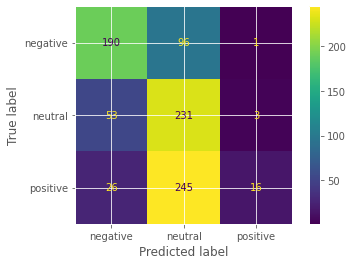


______________________________
Training: 
LinearSVC()
train time: 0.898
test time:  0.004s
accuracy: 0.674
f1: 0.658
confusion matrix:


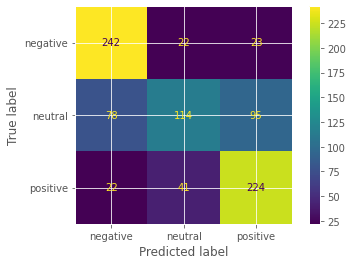


______________________________
Training: 
LogisticRegression()
train time: 0.387
test time:  0.004s
accuracy: 0.635
f1: 0.626
confusion matrix:


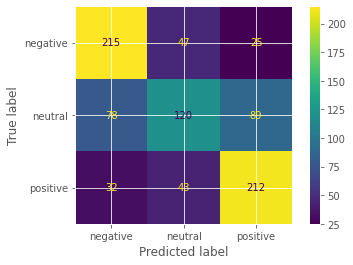


______________________________
Training: 
KNeighborsClassifier()
train time: 0.012
test time:  0.170s
accuracy: 0.630
f1: 0.620
confusion matrix:


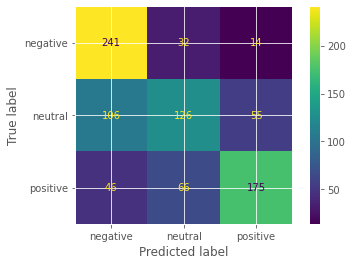


______________________________
Training: 
RandomForestClassifier()
train time: 3.521
test time:  0.043s
accuracy: 0.625
f1: 0.620
confusion matrix:


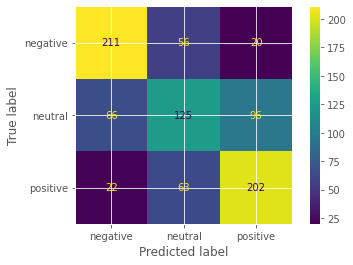

In [157]:
classifiers = [
    Perceptron(max_iter=50),
    LinearSVC(),
    LogisticRegression(),
    KNeighborsClassifier(),
    RandomForestClassifier(),
]

results = []
for clf in classifiers:
    results.append(benchmark(clf))

# Выводы 

- Мы использовали предобученные модели и получили какой-то базовый результат. На практике нужно использовать различные модели (например в этой задаче классифицируются тексты новостей, соответственно было бы целесообразно использовать модели, обученные не на Национальном Корпусе Русского Языка, а на Новостном корпусе, на корпусе Тайга, возможно их комбинациях, в том числе сочетание с Wikipedia).  
- Основной плюс от использования моделей, предобученных на больших корпусах - возможность работы со словами, которых не было в обучающих выборках, когда данных для обучения недостаточно, а так же когда входные данные могут измениться в процессе эксплуатации модели.  
- В следующей теме рассмотрим использование моделей RusVectores на других задачах.  